In [17]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
import sys
sys.path.append('../Environments/')
from ColoredGridWorld import SetUpInferenceSpace as setUp
from ColoredGridWorld.MDP import MDP
from ColoredGridWorld import OBMDP
from ColoredGridWorld import visualizations
sys.path.append('../Algorithms/')
from ActionInterpretation import ActionInterpretation
from ValueIteration import ValueIteration
from numpy.random import choice
from itertools import product
import random
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
import math

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
#given a state it converts it into a 10-D array of x,y coordinates followed by the belief probabilities for each env in the given order
def mapStateToFeatureArray(state, orderOfEnv):
    objectState = state[0]
    beliefStateDict = state[1]()
    objectList = [coord for coord in objectState]
    beliefList = [beliefStateDict[env] for env in orderOfEnv]
    return ([objectList[0]/5, objectList[1]/4] + beliefList)

In [4]:
"""Fitted Value Iteration algorithm using linear regression with polynomial features
    Input: 
    mStates: list of sampled joint states of the form ((x,y), HashableBelief object)
    mStatesArrays: list of  sampled states converted to 10-D array with the coordinates and probabilities scaled
    orderOfEnv: list of env in the order in which the joint state is converted to an array
    rewardFunction, transitionFunction, gamma (discount factor) and convergence tolerance of the MDP
    
    Output:
    model that can predict the approximate value of all joint states
"""

def fittedValueIteration(mStates, mStatesArrays, orderOfEnv, rewardFunction, transitionFunction, gamma, convergenceTolerance):
    mStatesArrays = np.array(mStatesArrays)
    Y = np.zeros(len(mStates))
    #scaler = preprocessing.StandardScaler().fit(mStatesArrays)
    polynomial_features= PolynomialFeatures(degree=2)
    #scaler.transform(mStatesArrays)
    x_poly = polynomial_features.fit_transform(mStatesArrays)
    reg = LinearRegression().fit(x_poly, Y)
    while(True):
        print(Y)
        delta = 0
        for state in mStates: 
            tempVal = Y[mStates.index(state)]
            #maxQvalue = max(rewardFunction(state, action, list(transitionFunction(state, action).keys())[0]) + gamma*reg.predict(polynomial_features.fit_transform(scaler.transform([mapStateToFeatureArray(list(transitionFunction(state, action).keys())[0], orderOfEnv)]))) for action in actions)
            maxQvalue = max(rewardFunction(state, action, list(transitionFunction(state, action).keys())[0]) + gamma*reg.predict(polynomial_features.fit_transform(([mapStateToFeatureArray(list(transitionFunction(state, action).keys())[0], orderOfEnv)]))) for action in actions)
            Y[mStates.index(state)] = maxQvalue
            delta = max(delta, abs(tempVal - maxQvalue))
        reg = LinearRegression().fit(x_poly, Y)
        if(delta<=convergenceTolerance):
            break
    return reg

In [5]:
"""Fitted Value Iteration algorithm using a neural network as the function approximator
    Input: 
    mStates: list of sampled joint states of the form ((x,y), HashableBelief object)
    mStatesArrays: list of  sampled states converted to 10-D array with the coordinates and probabilities scaled
    orderOfEnv: list of env in the order in which the joint state is converted to an array
    rewardFunction, transitionFunction, gamma (discount factor) and convergence tolerance of the MDP
    
    Output:
    model that can predict the approximate value of all joint states
"""
def fittedValueIteration2(mStates, mStatesArrays, orderOfEnv, rewardFunction, transitionFunction, gamma, convergenceTolerance):
    mStatesArrays = np.array(mStatesArrays)
    Y = np.zeros(len(mStates))
    model = keras.Sequential([
    layers.Dense(16, activation='tanh'),
    #layers.Dense(16, activation='tanh'),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    
    EPOCHS = 500

    model.fit(
  mStatesArrays, Y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)
    
    while(True):
        print(Y)
        delta = 0
        for state in mStates: 
            tempVal = Y[mStates.index(state)]
            maxQvalue = max(rewardFunction(state, action, list(transitionFunction(state, action).keys())[0]) + gamma*model.predict(([mapStateToFeatureArray(list(transitionFunction(state, action).keys())[0], orderOfEnv)])) for action in actions)
            Y[mStates.index(state)] = maxQvalue
            delta = max(delta, abs(tempVal - maxQvalue))
        model.fit(
  mStatesArrays, Y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)
        if(delta<=convergenceTolerance):
            break
    return model

In [6]:
dimensions = (5,6)
goals = [(5,2)]
goalState = (5,2)
actions = [(-1,0),(0,1),(0,-1),(1,0)]
goalNameDictionary = {(5,2):'goal'}
colourReward = {'white': 0, 'orange': 0, 'purple': 0, 'blue':0, 'yellow':10}
stateSpace = {(0,0): 'white',(0,1): 'white',(0,2): 'white',(0,3): 'white',(0,4): 'white', (1,0): 'blue',(1,1): 'orange', (1,2):'orange',(1,3):'orange',(1,4):'orange', (2,0): 'blue',(2,1):'purple', (2,2):'purple', (2,3):'purple', (2,4):'orange', (3,0): 'blue',(3,1):'purple',(3,2): 'blue',(3,3):'purple',(3,4):'orange', (4,0): 'blue', (4,1): 'blue', (4,2): 'blue',(4,3):'purple', (4,4):'orange', (5,0):'white',(5,1):'white', (5,2):'yellow', (5,3):'white', (5,4):'white'}
getMDP = MDP(dimensions, stateSpace, colourReward)
objectRewardFn = getMDP()

#set up for object-level value-iteration and inference
convergenceTolerance = 10e-3
gamma = 0.95
alpha = 20
eps = 0.05
hyperparameters = (convergenceTolerance, gamma, alpha, eps)
variableColours = ['orange', 'purple', 'blue']
variableReward = [0, -2]
constantRewardDict = {'white': 0, 'yellow': 10}


utilitySpace = setUp.buildUtilitySpace(variableColours, variableReward, constantRewardDict)
transitionSpace = [True]
worlds = setUp.buildWorldSpace(utilitySpace, transitionSpace)
envSpace = [(world, goal) for world, goal in product(worlds, goals)]
envMDPsAndPolicies = setUp.buildEnvPolicySpace(dimensions, stateSpace, actions, envSpace, hyperparameters)
actionInterpretation = ActionInterpretation(envMDPsAndPolicies)

#set up for OBMDP 
beta = 10
beliefGamma = 0.95
beliefAlpha = 20
beliefEps = 0.05
#bins = [0,0.2,0.4,0.6,0.8,1]
bins = [0,0.25,0.5,0.75,1] 
beliefSpacePossible = [{key:value for key, value in zip(envSpace, permutations)} for permutations in product(bins, repeat = len(envSpace))]
discreteBeliefSpace = [beliefDict for beliefDict in beliefSpacePossible if (sum(value for value in beliefDict.values())==1)]
hashableDiscreteBeliefSpace = [setUp.HashableBelief(beliefDict) for beliefDict in discreteBeliefSpace]
uniformPriorBelief = setUp.HashableBelief({(setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               })
hashableDiscreteBeliefSpace.append(uniformPriorBelief)
beliefUtilityFn = OBMDP.getBeliefUtility()
literalObserver = OBMDP.LiteralObserver(actionInterpretation, discreteBeliefSpace)
getNextBelief = literalObserver.getNextBelief

getOBMDP = OBMDP.OBMDP((setUp.HashableWorld(colourReward, True), goals[0]), True, beta, getMDP.transitionFunction, getNextBelief)
jointRewardFn = getOBMDP(objectRewardFn, beliefUtilityFn)
jointTransitionFn = getOBMDP.transitionFunction

In [7]:
#randomly sampling the m states the model will be trained on  
orderOfEnv = [(setUp.HashableWorld({'orange':0, 'purple':0, 'blue':0, 'white':0, 'yellow':10}, True),(5,2)), 
               (setUp.HashableWorld({'orange':0, 'purple':0, 'blue':-2, 'white':0, 'yellow':10}, True),(5,2)), 
               (setUp.HashableWorld({'orange':0, 'purple':-2, 'blue':0, 'white':0, 'yellow':10}, True),(5,2)), 
               (setUp.HashableWorld({'orange':-2, 'purple':0, 'blue':0, 'white':0, 'yellow':10}, True),(5,2)),
               (setUp.HashableWorld({'orange':0, 'purple':-2, 'blue':-2, 'white':0, 'yellow':10}, True),(5,2)),
               (setUp.HashableWorld({'orange':-2, 'purple':0, 'blue':-2, 'white':0, 'yellow':10}, True),(5,2)),
               (setUp.HashableWorld({'orange':-2, 'purple':-2, 'blue':0, 'white':0, 'yellow':10}, True),(5,2)),
               (setUp.HashableWorld({'orange':-2, 'purple':-2, 'blue':-2, 'white':0, 'yellow':10}, True),(5,2))]
mStatesArrays = []
mStates = []
m = 20
for i in range(m):
    x = np.random.randint(0,6)
    y = np.random.randint(0,5)
    while((x,y) == (5,2)):
        x = np.random.randint(0,6)
        y = np.random.randint(0,5)
    objectState = (x,y)
    beliefDict = {env: random.random() for env in orderOfEnv}
    total = sum(val for val in beliefDict.values())
    beliefDictNormalized = {env: (prob/total) for env, prob in beliefDict.items()}
    jointState = (objectState, setUp.HashableBelief(beliefDictNormalized)) 
    mStates.append(jointState)
    beliefList = [beliefDictNormalized[env] for env in orderOfEnv]
    stateArray = [x/5,y/4] + beliefList
    mStatesArrays.append(stateArray)

In [8]:
model = fittedValueIteration2(mStates, mStatesArrays, orderOfEnv, jointRewardFn, jointTransitionFn, gamma, convergenceTolerance)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[4.89661425e-01 4.84068215e-01 1.91838428e-01 3.03002644e+00
 4.59286839e-01 1.01587540e-02 3.71156991e-01 2.77295768e-01
 5.31362116e-01 4.43453342e-01 6.49857149e-03 2.70997524e-01
 1.96369365e-01 4.04670060e-01 9.08248778e-03 1.44307474e-02
 2.08955860e+00 9.99919415e+00 1.94630504e+00 8.50375056e-01]
[ 1.65668166  2.62021589  2.91681528  3.59585714  3.79904008  2.67721629
  2.47420645  2.41298008  3.51924801  2.67037892  0.08726657  1.417

[81.43514252 50.96689606 69.59802246 87.2517395  84.42796326 63.1334343
 44.94625092 84.70761871 84.35832977 83.24465179 64.61528778 84.35356903
 84.68357086 77.87792969 52.63598251 48.80390549 82.9694519  90.56768036
 84.05961609 78.78351593]
[81.90854645 51.35090256 69.95365143 87.7542038  84.90309143 63.52346039
 45.37817383 85.19549561 84.82837677 83.717453   65.2846756  84.84243011
 85.17074585 78.26013947 53.22259903 49.05773926 83.47502899 91.11965179
 84.57192993 79.34012604]
[82.41707611 51.8290596  70.37911987 88.26283264 85.39025116 63.98136139
 45.85626221 85.6911087  85.31290436 84.20940399 66.01657104 85.34340668
 85.66485596 78.68843079 53.93588638 49.49624634 84.00682068 91.69239807
 85.10369873 79.92547607]
[82.86290741 52.16584778 70.73394775 88.71854401 85.8313446  64.33661652
 46.16721344 86.13898468 85.75028992 84.64994049 66.55310822 85.79257202
 86.11196899 79.06990051 54.40752792 49.73068237 84.46485138 92.18269348
 85.56777191 80.4094696 ]
[83.29632568 52.49724

[88.44625854 58.17478943 76.15526581 94.15930939 91.16725922 70.1783371
 52.47818375 91.50965118 91.06737518 90.04903412 73.56627655 91.20968628
 91.46839905 84.18177795 61.60570908 55.33330536 90.20006561 98.12417603
 91.25453949 86.49271393]
[88.47801971 58.23538589 76.18858337 94.18759155 91.19395447 70.22267151
 52.54330826 91.53708649 91.09340668 90.07613373 73.62093353 91.23783112
 91.49558258 84.20529938 61.68275452 55.40198898 90.23377228 98.15990448
 91.28692627 86.53058624]
[88.50574493 58.29175568 76.21800232 94.21183777 91.21668243 70.26261139
 52.60361099 91.56053925 91.11548615 90.09926605 73.67082214 91.26196289
 91.51878357 84.22505951 61.75501633 55.46631622 90.26331329 98.19139099
 91.31517792 86.5641098 ]
[88.52966309 58.34417725 76.24381256 94.23229218 91.23568726 70.29852295
 52.65954971 91.58021545 91.13386536 90.11867523 73.71620941 91.28229523
 91.53821564 84.24130249 61.82270432 55.52643204 90.28891754 98.21889496
 91.33953094 86.59355164]
[88.5499649  58.39293

[88.32515717 58.88529205 76.09985352 93.94785309 90.91848755 70.34921265
 53.23059845 91.2790451  90.80150604 89.81019592 73.93875885 90.99578857
 91.23119354 83.85845947 62.6365509  56.15859222 90.12184906 98.08847809
 91.14322662 86.49963379]
[88.30674744 58.88674164 76.08295441 93.92745209 90.89720154 70.33612061
 53.23154831 91.25821686 90.77981567 89.78916168 73.92934418 90.97532654
 91.21018219 83.83521271 62.64305878 56.15920639 90.10446167 98.07182312
 91.12504578 86.48374176]
[88.28820038 58.88796234 76.06595612 93.90692139 90.87583923 70.32288361
 53.2322464  91.23727417 90.7580719  89.768013   73.91970062 90.95476532
 91.18908691 83.81188965 62.64919662 56.15943909 90.08694458 98.05506134
 91.10676575 86.4677124 ]
[88.26953888 58.88887024 76.04878998 93.88631439 90.85436249 70.30938721
 53.23258591 91.21624756 90.73622131 89.7467804  73.9098053  90.93409729
 91.16789246 83.78846741 62.65498352 56.15927124 90.06932831 98.03814697
 91.08836365 86.45153809]
[88.25079346 58.8895

[87.69286346 58.87662125 75.51377106 93.25320435 90.19591522 69.86682129
 53.19364548 90.5708313  90.0671463  89.09632111 73.57434082 90.29933929
 90.51741028 83.06987762 62.77076721 56.07654572 89.52485657 97.51395416
 90.52103424 85.94886017]
[87.67487335 58.87625885 75.49710846 93.23345184 90.175354   69.85275269
 53.192276   90.55069733 90.04628754 89.0760498  73.56378937 90.27951813
 90.49710083 83.04742432 62.77418137 56.07323456 89.50791168 97.49766541
 90.50339508 85.93328094]
[87.65692139 58.87589645 75.48046112 93.21374512 90.15485382 69.83869171
 53.19089508 90.5306015  90.02545166 89.05580902 73.5532608  90.259758
 90.4768219  83.0249939  62.77761841 56.06993103 89.4910202  97.48141479
 90.48577881 85.9177475 ]
[87.63899994 58.8755455  75.46385193 93.19407654 90.1343689  69.82463074
 53.18947983 90.51054382 90.00466919 89.0356369  73.54276276 90.24003601
 90.45661163 83.00262451 62.78108215 56.0666275  89.47415924 97.46522522
 90.4682312  85.90226746]
[87.62114716 58.875175

[87.09803772 58.87200165 74.9648056  92.59863281 89.51480103 69.39541626
 53.14625549 89.90340424 89.37582397 88.42546082 73.22926331 89.64269257
 89.84423065 82.3266983  62.89144516 55.96092224 88.96511078 96.97756958
 89.93830872 85.43772888]
[87.08097076 58.87196732 74.94905853 92.57982635 89.49523926 69.38163757
 53.1447258  89.8842392  89.35597992 88.40620422 73.21940613 89.62384033
 89.82489777 82.30536652 62.89497375 55.95727921 88.94908142 96.9622345
 89.92162323 85.42317963]
[87.0639267  58.8719368  74.93439484 92.56106567 89.47571564 69.36787415
 53.14313889 89.86509705 89.33615875 88.38699341 73.20957184 89.60501099
 89.80558777 82.28407288 62.89848328 55.95362473 88.93304443 96.9469223
 89.90496826 85.408638  ]
[87.04694366 58.87177658 74.92528534 92.54230499 89.45619202 69.35404205
 53.1420784  89.8459549  89.3163681  88.36781311 73.1997757  89.58618164
 89.78629303 82.26273346 62.90201187 55.94995117 88.917099   96.93159485
 89.88828278 85.39405823]
[87.02998352 58.870738

[79.9571228  72.2390213  75.64255524 83.41453552 80.39476776 72.97091675
 68.65745544 80.70949554 77.97645569 75.55498505 69.32448578 80.63246155
 80.6410141  75.57730865 68.2898407  67.92242432 81.19657898 89.51123047
 81.95370483 78.73521423]
[79.32959747 71.39540863 74.99229431 82.80322266 79.78144073 72.16028595
 67.78322601 80.09583282 77.38505554 74.92938232 68.41333771 80.01291656
 80.02572632 74.95830536 67.57234955 67.43154144 80.58403015 88.89227295
 81.34946442 78.16196442]
[78.77690887 70.68624115 74.42713165 82.25254822 79.23432922 71.48117065
 67.03826904 79.5453949  76.84802246 74.37800598 67.62597656 79.45851135
 79.47333527 74.4213028  66.94541931 66.99133301 80.0381012  88.33766174
 80.80833435 77.65466309]
[78.23818207 69.96916199 73.85169983 81.71735382 78.70465088 70.83803558
 66.33657837 79.01255798 76.31044769 73.81582642 66.81177521 78.92169952
 78.94046021 73.89717865 66.24492645 66.46089172 79.4956665  87.78985596
 80.27791595 77.14328766]
[77.73683167 69.2778

[69.48814392 58.61362457 63.02961731 72.70769501 70.33145905 61.2046814
 55.62868118 70.37915802 68.16080475 64.13634491 54.65919113 70.22834015
 70.35716248 66.65214539 55.39093399 58.87430954 69.30117798 78.56308746
 71.29929352 68.51589203]
[69.2598877  58.39515686 62.82621002 72.47396851 70.1020813  61.02825165
 55.4723587  70.14723206 67.93309021 63.88588715 54.46883011 69.99649811
 70.1261673  66.43790436 55.12752533 58.69076157 69.07446289 78.31687927
 71.06452179 68.27708435]
[69.02075195 58.13036346 62.57666397 72.23654938 69.86992645 60.79341507
 55.23396301 69.91501617 67.6881485  63.61829376 54.20191193 69.76284027
 69.89547729 66.19845581 54.7657814  58.41460037 68.82624817 78.05588531
 70.82150269 68.0201416 ]
[68.82706451 57.91283417 62.38444901 72.03819275 69.67605591 60.61455536
 55.07213593 69.71979523 67.49181366 63.3941803  54.00955582 69.56854248
 69.70066071 66.01130676 54.48888016 58.20613861 68.62685394 77.8404541
 70.61930084 67.8090744 ]
[68.64511871 57.698310

[67.00365448 55.39598846 60.40500259 70.17301178 67.9108963  58.63462448
 52.83925629 67.93966675 65.69769287 61.27809143 50.62336349 67.79076385
 67.93048096 64.24862671 50.15462494 55.40304184 66.6787796  75.56001282
 68.69135284 65.68781281]
[66.99690247 55.38588715 60.39742661 70.16483307 67.90402985 58.62835312
 52.83079529 67.93260956 65.69109344 61.26882935 50.59418869 67.78391266
 67.92349243 64.24200439 50.11518097 55.38845825 66.67094421 75.54636383
 68.68317413 65.67829132]
[66.99123383 55.37698364 60.39085007 70.15779877 67.89822388 58.62303543
 52.82327271 67.92662048 65.68558502 61.26079941 50.56669617 67.77812958
 67.91755676 64.2363739  50.07765579 55.37502289 66.66426086 75.53397369
 68.67613983 65.66991425]
[66.9865799  55.36923981 60.38527679 70.15183258 67.89344025 58.61866379
 52.81667709 67.92164612 65.68109131 61.25393295 50.54077911 67.77337646
 67.91265106 64.23170471 50.04196548 55.36268234 66.65866852 75.52279663
 68.67018127 65.66264343]
[66.9828949  55.3625

[67.1031189  55.44984436 60.47569275 70.23724365 68.00065613 58.7358284
 52.87794113 68.02572632 65.80416107 61.33975601 50.15832138 67.88452148
 68.01737976 64.33372498 49.43769073 55.2958374  66.76566315 75.48795319
 68.76105499 65.7258606 ]
[67.11051941 55.45713425 60.48231888 70.24378967 68.00766754 58.74319077
 52.88383102 68.03268433 65.81178284 61.34676361 50.15256119 67.89169312
 68.02433014 64.3404541  49.42600632 55.29838943 66.77309418 75.49128723
 68.76786041 65.73197937]
[67.11798859 55.46451569 60.48905182 70.25042725 68.01476288 58.75064087
 52.88978577 68.039711   65.81948853 61.35386276 50.14693832 67.8989563
 68.03136444 64.34725952 49.41447449 55.30101776 66.78058624 75.49471283
 68.77474976 65.73815155]
[67.12554169 55.47199631 60.49584961 70.25713348 68.02192688 58.75814056
 52.89581299 68.04682159 65.82727051 61.36105728 50.14146042 67.90628815
 68.03846741 64.35413361 49.40311813 55.30374527 66.78816986 75.49824524
 68.78170776 65.74441528]
[67.13315582 55.479560

In [9]:
def getPolicyDistribution(actionDict, func):
    return {action:func(actionDict[action]) for action in actionDict}

In [10]:
#sampling trajctories (20) using the softmax policy after getting a valid function approximator using fitted value iteration
actions = [(-1,0),(0,1),(0,-1),(1,0)]
alpha = 1 #to avoid a math range error with exp
trajectories = []
for i in range(20):
    state1 = ( (0,2), setUp.HashableBelief({(setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                               (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                               (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                               }) )
    mapStateToFeatureArray(state1, orderOfEnv)
    jointTraj = [state1]
    objectLevelTraj = [state1[0]]
    while(state1[0]!=(5,2)):
        actionsProbability = {action:math.exp(alpha*(jointRewardFn(state1, action, list(jointTransitionFn(state1, action).keys())[0]) + gamma*model.predict((([mapStateToFeatureArray(list(jointTransitionFn(state1, action).keys())[0], orderOfEnv)])))) )
                                   for action in actions}
        total = sum(val for val in actionsProbability.values())
        actionsProbabilityNormalized = getPolicyDistribution(actionsProbability, lambda x: (x/total)) 
        actionsProbabilityFinal = getPolicyDistribution(actionsProbabilityNormalized, lambda x: (x*(1-eps) + (eps/len(actions))))
        actionProbs = [actionsProbabilityFinal[action] for action in actions]
        actionIndex = (choice(len(actions), p=actionProbs))
        action = actions[actionIndex]
        nextJointStates = [nextJointState for nextJointState in jointTransitionFn(state1, action).keys()]
        nextJointStateProbs = [jointTransitionFn(state1, action)[nextJointState] for nextJointState in nextJointStates]
        jointStateIndex = (choice(len(nextJointStates), p=nextJointStateProbs)) 
        state1 = nextJointStates[jointStateIndex]
        objectLevelTraj.append(state1[0])
        jointTraj.append(state1)
    trajectories.append(objectLevelTraj)


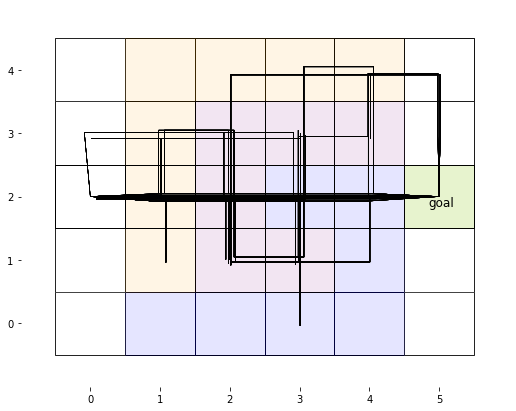

In [11]:
visualizations.visualizeEnvironmentMultipleTraj(stateSpace, [goalState], [], trajectories, goalNameDictionary, 1.75, 0, 0.04)

In [12]:
#to get the most likely trajectory with the given soft max policy using the model generated
alpha = 1
state1 = ( (0,2), setUp.HashableBelief({(setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                           (setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125, 
                                           (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                           (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                           (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                           (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                           (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                           (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                           }) )
mapStateToFeatureArray(state1, orderOfEnv)
jointTraj = [state1]
objectLevelTraj = [state1[0]]
while(state1[0]!=(5,2)):
    actionsProbability = {action:math.exp(alpha*(jointRewardFn(state1, action, list(jointTransitionFn(state1, action).keys())[0]) + gamma*model.predict((([mapStateToFeatureArray(list(jointTransitionFn(state1, action).keys())[0], orderOfEnv)])))) )
                                   for action in actions}
    total = sum(val for val in actionsProbability.values())
    actionsProbabilityNormalized = getPolicyDistribution(actionsProbability, lambda x: (x/total)) 
    actionsProbabilityFinal = getPolicyDistribution(actionsProbabilityNormalized, lambda x: (x*(1-eps) + (eps/len(actions))))
    print(actionsProbabilityFinal)
    action = max(actionsProbabilityFinal, key=actionsProbabilityFinal.get)
    state1 = max(jointTransitionFn(state1, action), key = jointTransitionFn(state1, action).get)
    #print(state1)
    objectLevelTraj.append(state1[0])
    jointTraj.append(state1)

{(-1, 0): 0.012500004554026408, (0, 1): 0.012504267572583067, (0, -1): 0.012500010158931079, (1, 0): 0.9624957177144593}
((1, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x0000020022CCFF48>)
{(-1, 0): 0.01589207545823235, (0, 1): 0.012500001577438719, (0, -1): 0.01250000004739364, (1, 0): 0.9591079229169353}
((2, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x000002001AF5F088>)
{(-1, 0): 0.018690488799780733, (0, 1): 0.014639139025179593, (0, -1): 0.19309817715591998, (1, 0): 0.7735721950191196}
((3, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x0000020020BFBF08>)
{(-1, 0): 0.3014633507402086, (0, 1): 0.1305757197116054, (0, -1): 0.21445375945849607, (1, 0): 0.35350717008969}
((4, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x0000020022213A08>)
{(-1, 0): 0.012539314900059604, (0, 1): 0.01254965434723382, (0, -1): 0.012527427384206292, (1, 0): 0.9623836033685003}
((5, 2), <ColoredGridWorld.SetUpIn

In [20]:
#getting the most likely trajectory without using the softmax policy
state1 = ( (0,2), setUp.HashableBelief({(setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                           (setUp.HashableWorld({'orange':0, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125, 
                                           (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125, 
                                           (setUp.HashableWorld({'orange':0, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                           (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                           (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':0, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                           (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':0, 'yellow':10}, True),(5,2)): 0.125,
                                           (setUp.HashableWorld({'orange':-2, 'white':0, 'blue':-2, 'purple':-2, 'yellow':10}, True),(5,2)): 0.125,
                                           }) )
mapStateToFeatureArray(state1, orderOfEnv)
jointTraj = [state1]
objectLevelTraj2 = [state1[0]]
maxVal = 0
maxAction = (0,0)
while(state1[0]!=(5,2)):
    for action in actions:
        qVal = (jointRewardFn(state1, action, list(jointTransitionFn(state1, action).keys())[0]) + gamma*model.predict((([mapStateToFeatureArray(list(jointTransitionFn(state1, action).keys())[0], orderOfEnv)]))))
        if(qVal>maxVal):
            maxVal = qVal
            maxAction = action
    state1 = list(jointTransitionFn(state1, maxAction).keys())[0]
    print(state1)
    objectLevelTraj2.append(state1[0])
    jointTraj.append(state1)

((1, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x000002001EDC0648>)
((2, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x000002001C25DA48>)
((3, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x000002002270B148>)
((4, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x000002001C2764C8>)
((5, 2), <ColoredGridWorld.SetUpInferenceSpace.HashableBelief object at 0x000002001EE33108>)


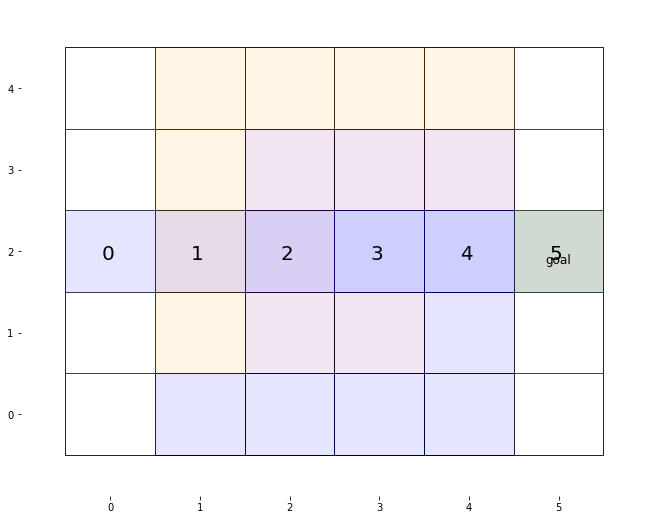

In [21]:
visualizations.visualizeEnvironmentByState(stateSpace, [goalState], [], objectLevelTraj2, goalNameDictionary, 2.25)

In [22]:
orderOfColours = ["orange", "purple", "blue"]
beliefsAtEachStep = [jointState[1]() for jointState in jointTraj]
beliefsAtEachStepFinal = [setUp.mapEnvToLabel(envDict, orderOfColours) for envDict in beliefsAtEachStep]

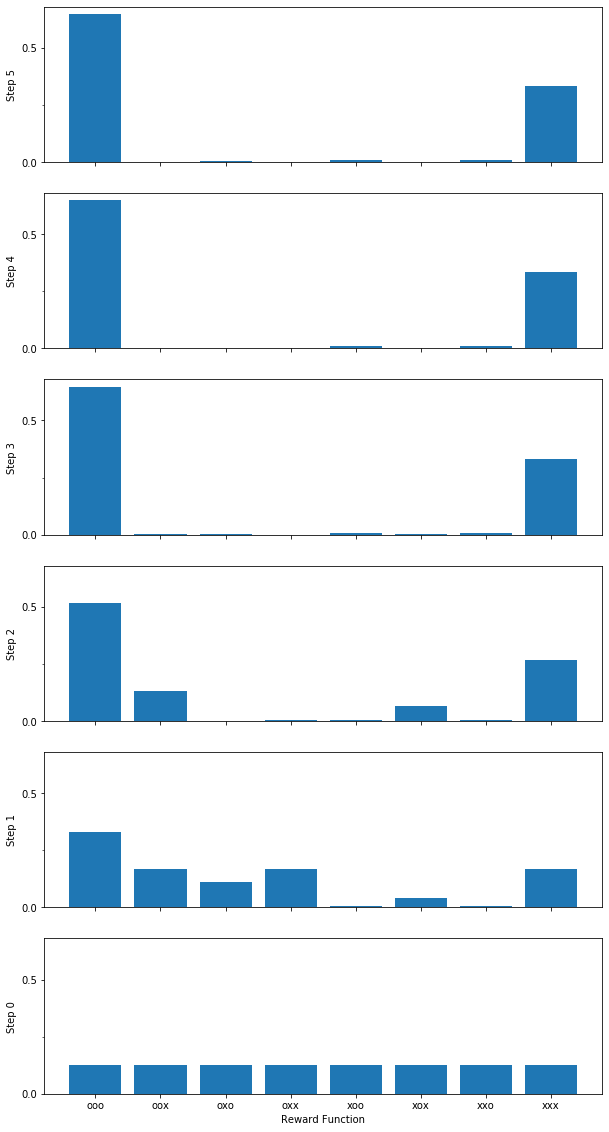

In [23]:
visualizations.plotDictAtEachStep(beliefsAtEachStepFinal)